Michelle Hu  
---
University of Washington  
AMATH 563  
Homework 2  
Due: May 2, 2020  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
wd = "/mnt/Backups/jmhu"

data_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/data/"
model_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/models/"
fig_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/figures/"
    
if not os.path.exists(data_dir):
    !mkdir $data_dir

if not os.path.exists(model_dir):
    !mkdir $model_dir

if not os.path.exists(fig_dir):
    !mkdir $fig_dir

### Load data

In [4]:
df = pd.read_csv(data_dir+"population_data.csv")
df.head()

,Year,Hare,Lynx
0,1845,20,32
1,1847,20,50
2,1849,52,12
3,1851,83,10
4,1853,64,13


## Question 3. Empirical Predator-Prey models such as Lotka-Volterra are commonly used to model such phenomenon. Consider the model x ̇ = (b − py)x and y ̇ = (rx − d)y. Use the data to fit values of b, p, r and d.


### APPROACH: Use SINDy with limited library to fit values for b, p, r and d using the data

#### Define functions

In [5]:
def lotka_volterra(t, x0, b, p, r, d):
    '''Empirical Lotka-Volterra predator-prey model'''
    x, y = x0
    xdot = (b - p*y) * x
    ydot = (r*x - d) * y
    return(xdot, ydot)


def densify(t,y,dt):
    '''From Friedrich'''
    from scipy.interpolate import interp1d
    f = interp1d(t, y, kind='cubic')
    tnew = np.arange(t[0], t[-1], dt)
    ynew = f(tnew)
    return(tnew, ynew)

#### Set up problem and calculate time derivatives

In [6]:
# Set up problem
X=df.Hare.values
Y=df.Lynx.values

t = df.Year.values
dt = (t[1] - t[0])/10 # make 10 times more points ()

# Interpolate for more points
years, X = densify(t, X, dt)
years, Y = densify(t, Y, dt)

# Calculate derivatives with center point finite difference
xdot=np.zeros_like(X)
ydot=np.zeros_like(Y)

for j in range(len(xdot)-1):
    if j == 0:
        pass
    else:
        xdot[j-1] = ( X[j+1]-X[j-1] ) / (2*dt)
        ydot[j-1] = ( Y[j+1]-Y[j-1] ) / (2*dt)
        
X.shape, Y.shape, xdot.shape, ydot.shape

((290,), (290,), (290,), (290,))

#### Reshape only with endpoints

In [7]:
# Toss endpoints
X=X[1:-1]
Y=Y[1:-1]
xdot=xdot[:-2]
ydot=ydot[:-2]

X.shape, Y.shape, xdot.shape, ydot.shape

((288,), (288,), (288,), (288,))

#### Create library of potential functions

In [8]:
AX = np.array([ X, X*Y])
AX_names = np.array([ "X", "XY"])

AY = np.array([ Y, X*Y])
AY_names = np.array([ "Y", "XY"])
AX.shape, len(AX_names), AY.shape, len(AY_names)

((2, 288), 2, (2, 288), 2)

#### Use linear regression with L1 normalization to find coefficient weights

In [9]:
%%time

hare_models = []
lynx_models = []

from sklearn import linear_model

# LASSO
lasso=linear_model.Lasso(random_state=43, max_iter=100000000)
lasso.fit(AX.T, xdot)
Xi_lasso=lasso.coef_
hare_models.append(lasso)

lasso=linear_model.Lasso(random_state=43, max_iter=100000000)
lasso.fit(AY.T, ydot)
Yi_lasso=lasso.coef_
print(Xi_lasso.shape, Yi_lasso.shape)
lynx_models.append(lasso)

# LASSO 0.8 alpha
lasso=linear_model.Lasso(random_state=43, max_iter=100000000, alpha=0.8)
lasso.fit(AX.T, xdot)
Xi_lasso8=lasso.coef_
hare_models.append(lasso)

lasso=linear_model.Lasso(random_state=43, max_iter=100000000, alpha=0.8)
lasso.fit(AY.T, ydot)
Yi_lasso8=lasso.coef_
print(Xi_lasso8.shape, Yi_lasso8.shape)
lynx_models.append(lasso)

# Least Angle Regression
lars = linear_model.LassoLars()
lars.fit(AX.T, xdot)
Xi_lars=lars.coef_
hare_models.append(lars)

lars = linear_model.LassoLars()
lars.fit(AY.T, ydot)
Yi_lars=lars.coef_
print(Xi_lars.shape, Yi_lars.shape)
lynx_models.append(lars)

(2,) (2,)
(2,) (2,)
(2,) (2,)
CPU times: user 162 ms, sys: 23.3 ms, total: 186 ms
Wall time: 185 ms


#### Plot weightings of solutions

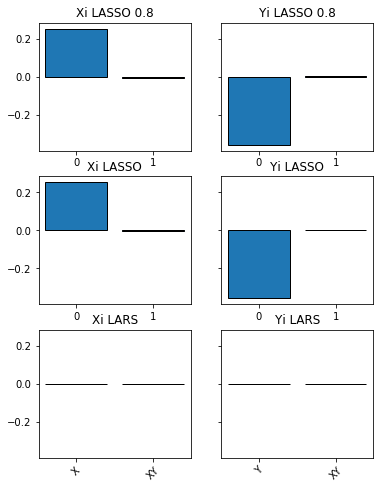

In [10]:
ec='k'

fig, ax = plt.subplots(3, 2, figsize=(6, 8), sharey=True)

# Xi 1 solutions
ax[0,0].bar(np.arange(len(AX)), Xi_lasso8, ec=ec, )
ax[1,0].bar(np.arange(len(AX)), Xi_lasso, ec=ec)
ax[2,0].bar(np.arange(len(AX)), Xi_lars, ec=ec)
ax[0,0].set_title("Xi LASSO 0.8")
ax[1,0].set_title("Xi LASSO")
ax[2,0].set_title("Xi LARS")

# Xi 2 solutions
ax[0,1].bar(np.arange(len(AY)), Yi_lasso8, ec=ec)
ax[1,1].bar(np.arange(len(AY)), Yi_lasso, ec=ec)
ax[2,1].bar(np.arange(len(AY)), Yi_lars, ec=ec)
ax[0,1].set_title("Yi LASSO 0.8")
ax[1,1].set_title("Yi LASSO")
ax[2,1].set_title("Yi LARS");

ticks=np.arange(len(AX_names))
rotation=45

ax[0,0].set_xticks(ticks)
ax[0,1].set_xticks(ticks)
ax[1,0].set_xticks(ticks)
ax[1,1].set_xticks(ticks)

ax[2,0].set_xticks(ticks)
ax[2,0].set_xticklabels(AX_names, rotation=rotation);

ax[2,1].set_xticks(ticks)
ax[2,1].set_xticklabels(AY_names, rotation=rotation);

#### Extract thresholded coefficients of models (L1 normalization)

In [11]:
thresh=1e-3

X_coefs = [Xi_lasso8, Xi_lasso, Xi_lars]
Y_coefs = [Yi_lasso8, Yi_lasso, Yi_lars]
models = ["lasso8", "lasso", "lars"]

for xi, yi, model in zip(X_coefs, Y_coefs, models):
    print(model)
    
    print("=== xdot dependent on: ===")
    for idx, j, in enumerate(np.abs(xi)>thresh):
            if j:
                print("{0:.4f}".format(xi[idx]), AX_names[idx])

    print("=== ydot dependent on: ===")
    for idx, k, in enumerate(np.abs(yi)>thresh):
        if k:
            print("{0:.4f}".format(yi[idx]), AY_names[idx])
    print("\n")

lasso8
=== xdot dependent on: ===
0.2543 X
-0.0055 XY
=== ydot dependent on: ===
-0.3585 Y
0.0034 XY


lasso
=== xdot dependent on: ===
0.2540 X
-0.0055 XY
=== ydot dependent on: ===
-0.3570 Y
0.0034 XY


lars
=== xdot dependent on: ===
=== ydot dependent on: ===




**Coefficients according to lasso L1 regularization (alpha = 1, 0.8):**  
b = 0.167  
p = -3.7e-3  
r = 2.7e-3  
d = -2.88e-3  

### Forecast population numbers based on Lasso coefficients

In [12]:
from scipy.integrate import solve_ivp

# Set up time span
t_range = [0, len(years)]

# instantiate initial conditions
x0 = (X[0], Y[0])

# Extract coefficients
b, p = np.abs(Xi_lasso)
d, r = np.abs(Yi_lasso)

# Derive IVP solution 
sol = solve_ivp(lotka_volterra, t_range, x0, 
                args=(b, p, r, d), dense_output=True)

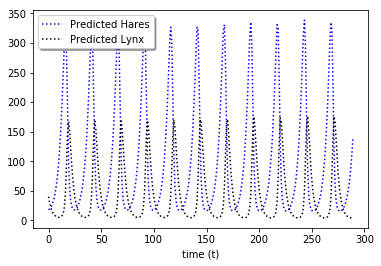

In [13]:
t = np.arange(0, len(years), 1)
predictions = sol.sol(t)

plt.plot(t, predictions[0].T, "b:", label="Predicted Hares")
plt.plot(t, predictions[1].T, "k:", label="Predicted Lynx")
plt.xlabel('time (t)')

plt.legend(shadow=True)
plt.show()

In [14]:
# Using Lotka-Volterra model, add paper control u(t)
def lotka_volterra_control(t, x0, b, p, r, d):
    '''Empirical Lotka-Volterra predator-prey model with SINDy-derived weightings 
    and published control function from https://arxiv.org/pdf/1605.06682.pdf'''
    x, y = x0
    xdot = (b - p*y) * x + (2*np.sin(t) + 2*np.sin(t/10))**2
    ydot = (r*x - d) * y
    
    return(xdot, ydot)

#### Derive IVP predictions

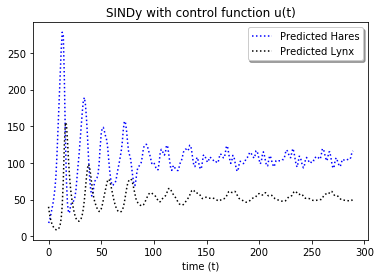

In [15]:
sol = solve_ivp(lotka_volterra_control, t_range, x0, 
                args=(b, p, r, d), dense_output=True)

t = np.arange(0, len(years), 1)
predictions = sol.sol(t)

plt.plot(t, predictions[0].T, "b:", label="Predicted Hares")
plt.plot(t, predictions[1].T, "k:", label="Predicted Lynx")
plt.xlabel('time (t)')
plt.title("SINDy with control function u(t)")
plt.legend(shadow=True)
plt.show()

### Coarsely input derived coefficients into the lotka volterra equation to extract predicted xdot and ydot

In [16]:
b, p = np.abs(Xi_lasso)
d, r = np.abs(Yi_lasso)
x0 = (X, Y)
xdot_hat, ydot_hat = lotka_volterra(t=None, x0=x0, 
                                    b=b, 
                                    p=p, 
                                    r=r, 
                                    d=d
                  )

#### Compute predicted x (x_hat) and y (y_hat) using predicted xdot and ydot

In [17]:
x_hat=np.zeros(X.shape)

for j in range(len(X)-2):
    x_hat[j+2]=X[j]+4*xdot_hat[j+1]

y_hat=np.zeros(Y.shape)

for j in range(len(Y)-2):
    y_hat[j+2]=Y[j]+4*ydot_hat[j+1]

# reshape
x_hat=x_hat[2:]
y_hat=y_hat[2:]

#### Plot true and predicted populations with fitted values of b, p, r and d

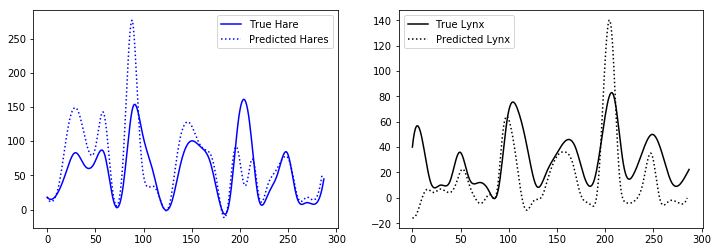

In [18]:
fig, axes=plt.subplots(1, 2, sharex=True, figsize=(12, 4))
axes[0].plot(X, "b", label="True Hare")
axes[0].plot(x_hat, "b:", label="Predicted Hares")
axes[0].legend()

axes[1].plot(Y, "k", label="True Lynx")
axes[1].plot(y_hat, "k:", label="Predicted Lynx")
axes[1].legend()

## Question 4. Find the best fit nonlinear, dynamical systems model to the data using sparse regression.

In [19]:
# Set up problem
x1=df.Hare.values
x2=df.Lynx.values
t = df.Year.values

# Interpolate for more points
dt = (t[1] - t[0])/10 # make 10 times more points ()

years, x1 = densify(t, x1, dt)
years, x2 = densify(t, x2, dt)

# Calculate derivatives with center point finite difference
dx1=np.zeros_like(x1)
dx2=np.zeros_like(x2)

dt=2

for j in range(len(dx1)-1):
    if j == 0:
        pass
    else:
        dx1[j-1] = ( x1[j+1]-x1[j-1] ) / (2*dt)
        dx2[j-1] = ( x2[j+1]-x2[j-1] ) / (2*dt)
        
x1.shape, x2.shape, dx1.shape, dx2.shape

((290,), (290,), (290,), (290,))

In [20]:
# Toss endpoints
x1s=x1[1:-1]
x2s=x2[1:-1]
dx1=dx1[:-2]
dx2=dx2[:-2]

x1s.shape, x2s.shape, dx1.shape, dx2.shape

((288,), (288,), (288,), (288,))

In [21]:
# Create library of potential functions based on
A = np.array([ x1s, x2s, x1s**2, x1s*x2s, x2s**2, 
              x1s**3, x1s*x2s**2, x1s**2*x2s, x2s**3, 
              np.sin(x1s), np.cos(x2s), np.sin(x2s), np.cos(x1s), 
              np.sin(2*x1s), np.cos(2*x2s), np.sin(2*x2s), np.cos(2*x1s),
              1/np.sin(x1s), 1/np.cos(x2s), 1/np.sin(x2s), 1/np.cos(x1s) 
             ])
A_names=["x1s", "x2s", "x1s**2", "x1s*x2s", "x2s**2", 
              "x1s**3", "x1s*x2s**2", "x1s**2*x2s", "x2s**3", 
              "np.sin(x1s)", "np.cos(x2s)", "np.sin(x2s)", "np.cos(x1s)", 
              "np.sin(2*x1s)", "np.cos(2*x2s)", "np.sin(2*x2s)", "np.cos(2*x1s)",
              "1/np.sin(x1s)", "1/np.cos(x2s)", "1/np.sin(x2s)", "1/np.cos(x1s)"
        ]
A.shape, len(A_names)

((21, 288), 21)

#### Use various solvers with L1 regularization to find function weights

In [22]:
%%time
# solve for vector xi (the weights/coefficients) using regression approach
# dx_dt = A @ xi

# Pseudoinverse
xi1_pinv=np.linalg.pinv(A.T) @ dx1
xi2_pinv=np.linalg.pinv(A.T) @ dx2
print(xi1_pinv.shape, xi2_pinv.shape)

from sklearn import linear_model

max_iter=1e5

# LASSO
lasso=linear_model.Lasso(random_state=0, max_iter=max_iter)
lasso.fit(A.T, dx1)
xi1_lasso=lasso.coef_
hare_models.append(lasso)

lasso=linear_model.Lasso(random_state=0, max_iter=max_iter)
lasso.fit(A.T, dx2)
xi2_lasso=lasso.coef_
print(xi1_lasso.shape, xi2_lasso.shape)
lynx_models.append(lasso)

# LASSO alpha = 0.8
lasso=linear_model.Lasso(random_state=0, max_iter=max_iter, alpha=0.8)
lasso.fit(A.T, dx1)
xi1_lasso8=lasso.coef_
hare_models.append(lasso)

lasso=linear_model.Lasso(random_state=0, max_iter=max_iter, alpha=0.8)
lasso.fit(A.T, dx2)
xi2_lasso8=lasso.coef_
print(xi1_lasso8.shape, xi2_lasso8.shape)
lynx_models.append(lasso)

# Least Angle Regression
lars = linear_model.LassoLars()
lars.fit(A.T, dx1)
xi1_lars=lars.coef_
hare_models.append(lars)

lars = linear_model.LassoLars()
lars.fit(A.T, dx2)
xi2_lars=lars.coef_
lynx_models.append(lars)
print(xi1_lars.shape, xi2_lars.shape)

(21,) (21,)
(21,) (21,)
(21,) (21,)
(21,) (21,)
CPU times: user 41.1 ms, sys: 354 µs, total: 41.5 ms
Wall time: 40.5 ms


#### Plot weightings of solutions

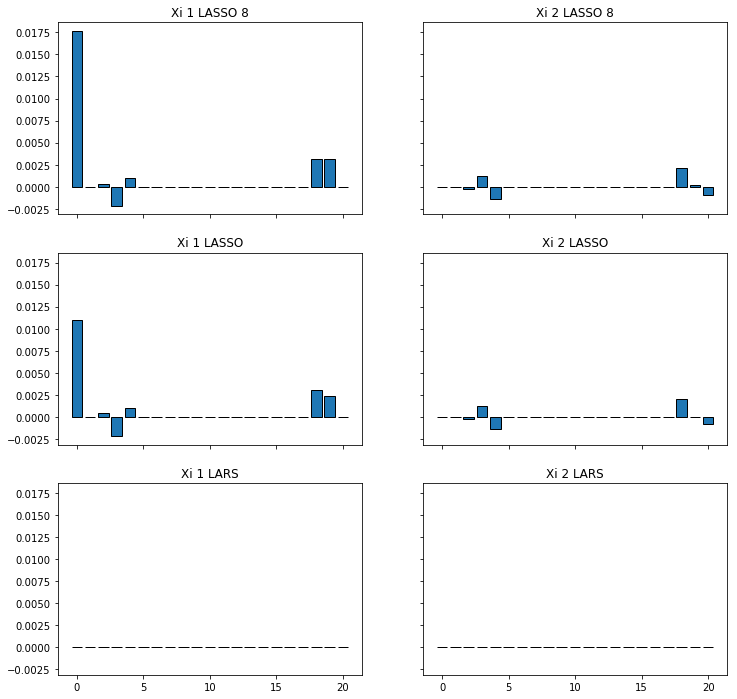

In [23]:
ec='k'

fig, ax = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=True)

# Xi 1 solutions
ax[0,0].bar(np.arange(len(A)), xi1_lasso8, ec=ec)
ax[1,0].bar(np.arange(len(A)), xi1_lasso, ec=ec)
ax[2,0].bar(np.arange(len(A)), xi1_lars, ec=ec)
ax[0,0].set_title("Xi 1 LASSO 8")
ax[1,0].set_title("Xi 1 LASSO")
ax[2,0].set_title("Xi 1 LARS")

# Xi 2 solutions
ax[0,1].bar(np.arange(len(A)), xi2_lasso8, ec=ec)
ax[1,1].bar(np.arange(len(A)), xi2_lasso, ec=ec)
ax[2,1].bar(np.arange(len(A)), xi2_lars, ec=ec)
ax[0,1].set_title("Xi 2 LASSO 8")
ax[1,1].set_title("Xi 2 LASSO")
ax[2,1].set_title("Xi 2 LARS");

In [24]:
# Set up candidate function tick names
A_names_sub=A_names[::2]
ticks=np.arange(len(A_names))
ticks=ticks[::2]

#### Zoom in on LASSO solutions

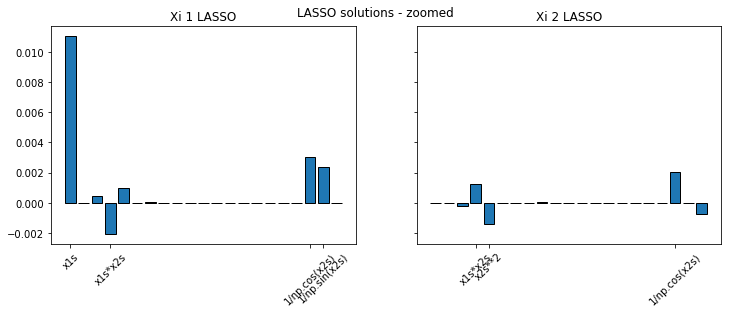

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
plt.subplots_adjust(hspace=0.4)

ax[0].bar(np.arange(len(A)), xi1_lasso, ec=ec)
ax[0].set_title("Xi 1 LASSO")

ax[1].bar(np.arange(len(A)), xi2_lasso, ec=ec)
ax[1].set_title("Xi 2 LASSO")

plt.suptitle("LASSO solutions - zoomed", y=0.95);

### ==== Axis ticklabels === ###
thresh=1e-3
rotation=45

def good_functions(xi, thresh, A_name):
    '''First get indices of coefficients larger than threshold
    Then extract library candidate function names based on indices
    '''
    xi_ind=(np.indices(xi.shape).squeeze())[np.abs(xi)>thresh] 
    xi_names=[ A_name[x] for x in xi_ind ] 
    return(xi_ind, xi_names)

# LASSO solutions
xi1_lasso_ind, xi1_lasso_names = good_functions(xi1_lasso, thresh, A_names)
xi2_lasso_ind, xi2_lasso_names = good_functions(xi2_lasso, thresh, A_names)

ax[0].set_xticks(xi1_lasso_ind)
ax[0].set_xticklabels(xi1_lasso_names, rotation=rotation)

ax[1].set_xticks(xi2_lasso_ind)
ax[1].set_xticklabels(xi2_lasso_names, rotation=rotation);

#### Extract thresholded coefficients of models

In [26]:
xi1_coefs = [xi1_lasso8, xi1_lasso, xi1_lars]
xi2_coefs = [xi2_lasso8, xi2_lasso, xi2_lars]
models = ["lasso8", "lasso", "lars"]

A_names=np.array(A_names)

for i, (xi1, xi2, model) in enumerate(zip(xi1_coefs, xi2_coefs, models)):
    if i == 1:
        print(model)
        print("=== dx1 dependent on: ===")
        for idx, j, in enumerate(np.abs(xi1)>thresh):
            if j:
                print("{0:.5f}".format(xi1[idx]), A_names[idx])

        print("=== dx2 dependent on: ===")
        for idx, k, in enumerate(np.abs(xi2)>thresh):
            if k:
                print("{0:.5f}".format(xi2[idx]), A_names[idx])

lasso
=== dx1 dependent on: ===
0.01105 x1s
-0.00208 x1s*x2s
0.00305 1/np.cos(x2s)
0.00237 1/np.sin(x2s)
=== dx2 dependent on: ===
0.00127 x1s*x2s
-0.00140 x2s**2
0.00204 1/np.cos(x2s)


#### Use models and coefficients to predict number of hares and lynx for the given time period

In [27]:
def new_model(t, x0, a, b, c, d, e, f, g):
    '''SINDy model'''
    x, y = x0
    xdot = a*x + b*x*y + c/np.cos(y) + d/np.sin(y)
    ydot = e*x*y + f*y**2 + g/np.cos(y)
    return(xdot, ydot)

In [28]:
# Compute predicted time derivatives
a, b, c, d = xi1_lasso[np.abs(xi1_lasso)>thresh]
e, f, g = xi2_lasso[np.abs(xi2_lasso)>thresh]

x0 =(x1s, x2s)

dx1_hat, dx2_hat = new_model(t=None, x0=x0,
                             a=a, b=b, c=c, d=d,
                             e=e, f=f, g=g
                            )
# Set up time span for IVP
t_range = [0, len(years)]

# instantiate initial conditions
x0=(x1s[0], x2s[0])

# Derive IVP solution 
sol = solve_ivp(lotka_volterra, t_range, x0, 
                args=(b, p, r, d), dense_output=True)

#### Plot IVP forecast

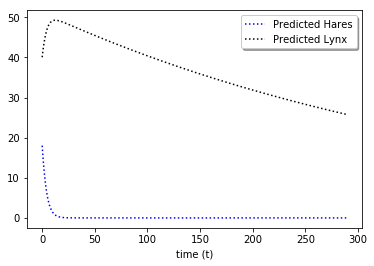

In [29]:
t = np.arange(0, len(years), 1)
predictions = sol.sol(t)

plt.plot(t, predictions[0].T, "b:", label="Predicted Hares")
plt.plot(t, predictions[1].T, "k:", label="Predicted Lynx")
plt.xlabel('time (t)')

plt.legend(shadow=True)
plt.show()

#### Compute predicted hares and lynxs

In [30]:
x1_hat=np.zeros(x1s.shape)

for j in range(len(x1s)-2):
    x1_hat[j+2]=x1s[j]+4*dx1_hat[j+1]

x2_hat=np.zeros(x2s.shape)

for j in range(len(x2s)-2):
    x2_hat[j+2]=x2s[j]+4*dx2_hat[j+1]

# reshape
x1_hat=x1_hat[2:]
x2_hat=x2_hat[2:]

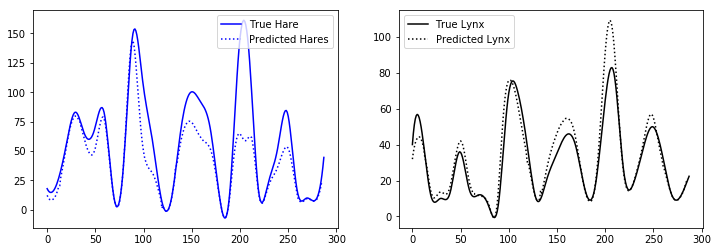

In [31]:
fig, axes=plt.subplots(1, 2, sharex=True, figsize=(12, 4))
axes[0].plot(x1s, "b", label="True Hare")
axes[0].plot(x1_hat, "b:", label="Predicted Hares")
axes[0].legend()

axes[1].plot(x2s, "k", label="True Lynx")
axes[1].plot(x2_hat, "k:", label="Predicted Lynx")
axes[1].legend()

### Save models in model directory

#### Set up model filenames

In [32]:
model_fns = ["lasso_restricted", "lasso8_restricted", "lars_restricted", "lasso", "lasso8", "lars"]
model_fns = [model_dir + model for model in model_fns]

hare_model_fns = [ model + "_hare.pkl" for model in model_fns]
lynx_model_fns = [ model + "_lynx.pkl" for model in model_fns]

#### Use pickle to dump to file

In [33]:
for hare_fn, lynx_fn, hare_model, lynx_model in zip(hare_model_fns, lynx_model_fns, hare_models, lynx_models):
    if not os.path.exists(hare_fn):
        with open(hare_fn, "wb") as file:
            pickle.dump(hare_model, file)   
    else:
        print(hare_fn.split('/')[-1][:-4], "exists")
    if not os.path.exists(lynx_fn):
        with open(lynx_fn, "wb") as file:
            pickle.dump(lynx_model, file)    
    else:
        print(lynx_fn.split('/')[-1][:-4], "exists")

In [34]:
hare_model_fns

['/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/lasso_restricted_hare.pkl',
 '/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/lasso8_restricted_hare.pkl',
 '/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/lars_restricted_hare.pkl',
 '/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/lasso_hare.pkl',
 '/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/lasso8_hare.pkl',
 '/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/lars_hare.pkl']

In [35]:
lynx_model_fns

['/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/lasso_restricted_lynx.pkl',
 '/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/lasso8_restricted_lynx.pkl',
 '/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/lars_restricted_lynx.pkl',
 '/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/lasso_lynx.pkl',
 '/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/lasso8_lynx.pkl',
 '/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/lars_lynx.pkl']